In [131]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from csbdeep.utils.tf import keras_import
keras = keras_import()
from stardist import random_label_cmap
import os
from glob import glob
import pandas as pd

np.random.seed(0)
cmap = random_label_cmap()

In [22]:
pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims'  # path of tif files
WSIs = sorted(glob(f'{pth}\*.tif'))

In [23]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(img, **kwargs)
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
    ax[1].imshow(cropped_img, **kwargs)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [24]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [25]:
# segment DAPI_Cy5 combined im
img = imread(WSIs[0])
img = img/255

labels_Cy5, polys_Cy5 = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


In [26]:
# segment DAPI_IBA combined im
img = imread(WSIs[1])
img = img/255

labels_IBA, polys_IBA = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 24/24 [00:49<00:00,  2.05s/it]


In [27]:
WSIs

['C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\combined_ims\\DAPI_Cy5.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\combined_ims\\DAPI_IBA.tif']

In [28]:
from scipy.io import loadmat
import h5py

def load_var_from_mat(mat_file_name, varname):
    try:
        data = loadmat(mat_file_name)
        var = data[varname]
    except:
        data = h5py.File(mat_file_name, 'r')
        var = data[varname][()]
    return var

In [29]:
pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims\coords_for_stardist'

Cy5_coords = load_var_from_mat(os.path.join(pth, 'Cy5_coords.mat'), "Cy5_coords")

IBA_coords = load_var_from_mat(os.path.join(pth, 'IBA_coords.mat'), "IBA_coords")

In [30]:
adj_x_Cy5 = [x for x in Cy5_coords[:,0]]
adj_y_Cy5 = [y for y in Cy5_coords[:,1]]
adj_Cy5_coords = np.transpose(np.array([adj_x_Cy5, adj_y_Cy5]))

adj_x_IBA = [x for x in IBA_coords[:,0]]
adj_y_IBA = [y for y in IBA_coords[:,1]]
adj_IBA_coords = np.transpose(np.array([adj_x_IBA, adj_y_IBA]))

In [31]:
def is_point_encompassed(xy_point, set_of_points):
    x, y = xy_point
    min_x, max_x = min(point[0] for point in set_of_points), max(point[0] for point in set_of_points)
    min_y, max_y = min(point[1] for point in set_of_points), max(point[1] for point in set_of_points)
    return min_x <= x <= max_x and min_y <= y <= max_y

In [60]:
# for Cy5 coords:

in_tile_inds = []
poly_inds = []

in_tile = []
for num, i in enumerate(polys_Cy5['coord']):
    xy = np.transpose(i)
    # get centroids of poly
    x_cent = np.mean(xy[:,1])  # reversed order, idk why
    y_cent = np.mean(xy[:,0])
    
    # fix orientation of coordinates in matrix
    x = [x for x in xy[:,0]]
    y = [y for y in xy[:,1]]
    xy = np.transpose(np.array([x, y]))[:, ::-1]

    
    in_tile.append([xy])  # just for testing, delete later probably
    #print(xy)
    
    # instead of searching through entire list of positive cells, just do the ones that are within 100 pixel box
    condition = (
    (adj_Cy5_coords[:, 0] > (x_cent - 100)) & 
    (adj_Cy5_coords[:, 0] < (x_cent + 100)) & 
    (adj_Cy5_coords[:, 1] > (y_cent - 100)) & 
    (adj_Cy5_coords[:, 1] < (y_cent + 100))
    )
    subset_cords = adj_Cy5_coords[condition]

    for xy_cy5 in subset_cords:
        
        if is_point_encompassed(xy_cy5, xy):
            in_tile_ind = len(in_tile) - 1
            in_tile_inds.append(in_tile_ind)
            
            poly_inds.append(num)
            print(num, x_cent, y_cent)
            break

0 3862.4934692382812 3668.2821350097656
17 3958.3559646606445 3580.6664810180664
54 6168.241310119629 2771.853843688965
57 4729.806270599365 3448.3691787719727
59 6917.900764465332 2875.810012817383
61 4710.102226257324 3425.9141387939453
62 5958.263870239258 1980.212718963623
64 6272.570053100586 3324.2285690307617
65 6586.554710388184 1944.174057006836
67 5149.8159103393555 3249.6064453125
68 6303.954025268555 2386.196502685547
69 5771.8908767700195 3225.668991088867
72 4552.377899169922 3084.064956665039
73 6897.998672485352 2240.0041427612305
74 6213.534255981445 2060.343215942383
75 5411.312896728516 2772.092170715332
76 6903.884925842285 1549.8520469665527
80 5966.426094055176 3217.497360229492
81 5550.574104309082 3055.915870666504
82 4721.577823638916 3370.079216003418
83 5966.453575134277 3269.7634887695312
90 6255.396942138672 3525.430206298828
93 6316.447891235352 3837.9389419555664
94 5723.372619628906 2458.082733154297
96 4081.864330291748 3652.543342590332
97 5817.9775924

In [64]:
# stardist got shapes for this ratio of positive cells
print(len(poly_inds)/len(adj_Cy5_coords))

0.6364033809385019


In [67]:
import cv2
def cntarea(cnt):
    cnt = np.array(cnt).astype(np.float32)
    area = cv2.contourArea(cnt)
    return area

In [110]:
crop_x=12500
crop_y=12500
tile_size=1024

img = imread(WSIs[0])
img = img/255

cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

In [111]:
valid_shapes = polys_Cy5['coord'][poly_inds]

# crop, adj by crop_x and crop_y
#adj_x = [x - crop_x for x in valid_shapes[0,:]]
#adj_y = [y - crop_y for y in valid_shapes[1,:]]

#adj_valid_shapes = np.transpose(np.array([adj_x, adj_y]))


In [112]:
new_shapes = []
new_shapes_areas = []
for i in range(len(valid_shapes)):
    adj_x = [x - crop_x for x in valid_shapes[i][0,:]]
    adj_y = [y - crop_y for y in valid_shapes[i][1,:]]
    new_shape = np.transpose(np.array([adj_x, adj_y]))
    if all(tile_size > value > 0 for value in adj_x) and all(tile_size > value > 0 for value in adj_y):
        new_shapes.append(new_shape)
        area = cntarea(new_shape)
        new_shapes_areas.append(area)
        # print(new_shape)

In [113]:
new_shapes_areas

[567.9129520058632,
 693.2873589247465,
 515.2500804662704,
 354.12000647187233,
 416.6334470361471,
 456.87973338365555,
 571.6301299929619,
 375.4381536245346,
 788.460498418659]

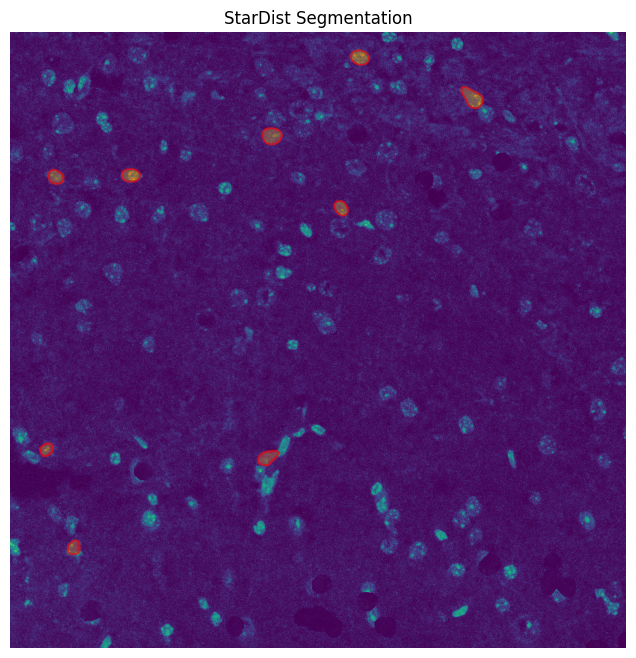

In [114]:
_, ax = plt.subplots(1,1,figsize = (24, 8))

ax.imshow(cropped_img)
ax.axis('off')
# ax.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1], c="r")
ax.set_title('Overlay')

for polygon in new_shapes:
    x_coords, y_coords = polygon[:,1], polygon[:,0]
    #print(x_coords, y_coords)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'

    ax.plot(x_coords, y_coords, alpha=0.4, color=color)
    ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('StarDist Segmentation')

plt.show()

In [119]:
shapes_areas = []
for i in range(len(valid_shapes)):
    adj_x = [x for x in valid_shapes[i][0,:]]
    adj_y = [y for y in valid_shapes[i][1,:]]
    new_shape = np.transpose(np.array([adj_x, adj_y]))
    shapes_areas.append(cntarea(new_shape))

In [132]:
# x, y, area
output = []

for i, (x_list, y_list) in enumerate(valid_shapes):
    x = round(np.mean(x_list))
    y = round(np.mean(y_list))
    area = shapes_areas[i]
    
    row = [x, y, area]
    output.append(row)

output = np.array(output)
output = pd.DataFrame(output)

In [134]:
output.head()

,0,1,2
0,3668.0,3862.0,575.003938
1,3581.0,3958.0,124.167059
2,2772.0,6168.0,579.558658
3,3448.0,4730.0,294.628566
4,2876.0,6918.0,451.167262


In [135]:
from scipy.io import savemat

nm = 'Cy5_coords_with_area.mat'
outpth = fr'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims\x_y_area_mats\{nm}'

savemat(outpth, {'x_y_area':output})

In [136]:
# for IBA coords:

in_tile_inds = []
poly_inds = []

in_tile = []
for num, i in enumerate(polys_IBA['coord']):
    xy = np.transpose(i)
    # get centroids of poly
    x_cent = np.mean(xy[:,1])  # reversed order, idk why
    y_cent = np.mean(xy[:,0])
    
    # fix orientation of coordinates in matrix
    x = [x for x in xy[:,0]]
    y = [y for y in xy[:,1]]
    xy = np.transpose(np.array([x, y]))[:, ::-1]

    
    in_tile.append([xy])  # just for testing, delete later probably
    #print(xy)
    
    # instead of searching through entire list of positive cells, just do the ones that are within 100 pixel box
    condition = (
    (adj_IBA_coords[:, 0] > (x_cent - 100)) & 
    (adj_IBA_coords[:, 0] < (x_cent + 100)) & 
    (adj_IBA_coords[:, 1] > (y_cent - 100)) & 
    (adj_IBA_coords[:, 1] < (y_cent + 100))
    )
    subset_cords = adj_IBA_coords[condition]

    for xy_cy5 in subset_cords:
        
        if is_point_encompassed(xy_cy5, xy):
            in_tile_ind = len(in_tile) - 1
            in_tile_inds.append(in_tile_ind)
            
            poly_inds.append(num)
            print(num, x_cent, y_cent)
            break

0 3822.5010833740234 3696.243194580078
9 3558.6416015625 3561.586357116699
10 3938.2529373168945 3478.4180297851562
15 3751.687126159668 3907.995803833008
17 3685.631996154785 3617.913787841797
18 3493.955764770508 3626.6611938476562
20 3927.7644577026367 3615.846664428711
21 3958.112403869629 3580.4007263183594
22 3865.180862426758 3664.936836242676
23 3918.0294342041016 3633.805465698242
27 3917.7065658569336 3624.6592864990234
28 3504.009307861328 3817.430244445801
29 3409.6772384643555 3648.7149200439453
33 3736.1034240722656 3521.7777709960938
40 3670.443717956543 3765.8553466796875
44 3923.63330078125 3500.437286376953
48 3706.257911682129 3585.9307556152344
49 3750.3356323242188 3575.4906463623047
52 3785.979293823242 3663.7032775878906
53 3359.931495666504 3608.1918182373047
56 3501.706039428711 3640.5264205932617
63 3391.970588684082 3633.8156509399414
67 3375.9861450195312 3623.3940505981445
69 3837.7768936157227 3583.7517471313477
70 3622.4973754882812 3777.325698852539
72 3

In [137]:
valid_shapes = polys_IBA['coord'][poly_inds]

In [148]:
crop_x=12500 # og 
crop_y=12500 # og
tile_size=1024 + 100

img = imread(WSIs[1])
img = img/255
cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

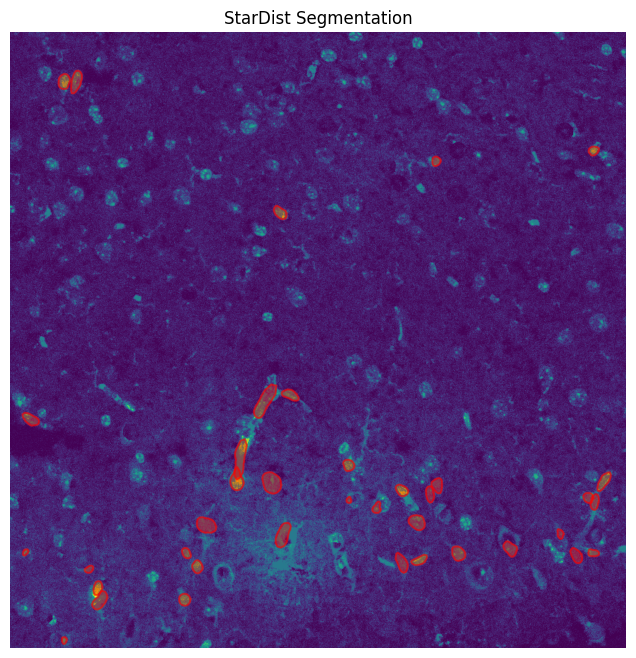

In [149]:
new_shapes = []
new_shapes_areas = []
for i in range(len(valid_shapes)):
    adj_x = [x - crop_x for x in valid_shapes[i][0,:]]
    adj_y = [y - crop_y for y in valid_shapes[i][1,:]]
    new_shape = np.transpose(np.array([adj_x, adj_y]))
    if all(tile_size > value > 0 for value in adj_x) and all(tile_size > value > 0 for value in adj_y):
        new_shapes.append(new_shape)
        area = cntarea(new_shape)
        new_shapes_areas.append(area)
        # print(new_shape)



_, ax = plt.subplots(1,1,figsize = (24, 8))

ax.imshow(cropped_img)
ax.axis('off')
# ax.scatter(adj_Cy5_coords[:,0], adj_Cy5_coords[:,1], c="r")
ax.set_title('Overlay')

for polygon in new_shapes:
    x_coords, y_coords = polygon[:,1], polygon[:,0]
    #print(x_coords, y_coords)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'

    ax.plot(x_coords, y_coords, alpha=0.4, color=color)
    ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('StarDist Segmentation')

plt.show()

In [139]:
shapes_areas = []
for i in range(len(valid_shapes)):
    adj_x = [x for x in valid_shapes[i][0,:]]
    adj_y = [y for y in valid_shapes[i][1,:]]
    new_shape = np.transpose(np.array([adj_x, adj_y]))
    shapes_areas.append(cntarea(new_shape))

In [140]:
# x, y, area
output = []

for i, (x_list, y_list) in enumerate(valid_shapes):
    x = round(np.mean(x_list))
    y = round(np.mean(y_list))
    area = shapes_areas[i]
    
    row = [x, y, area]
    output.append(row)

output = np.array(output)
output = pd.DataFrame(output)

In [141]:
output.head()

,0,1,2
0,3696.0,3823.0,451.532540
1,3562.0,3559.0,451.108475
2,3478.0,3938.0,364.655611
3,3908.0,3752.0,285.454322
4,3618.0,3686.0,311.489096


In [142]:
nm = 'IBA_coords_with_area.mat'
outpth = fr'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1\combined_ims\x_y_area_mats\{nm}'

savemat(outpth, {'x_y_area':output})